In [2]:
import os
import torchaudio
import torch
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
import jiwer

def load_audio(file_path):
    waveform, sample_rate = torchaudio.load(file_path)
    if sample_rate != 16000:
        waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)(waveform)
    waveform = torchaudio.transforms.Vol(1.0, gain_type='amplitude')(waveform)
    return waveform.squeeze().numpy()

def read_text(file_path):
    with open(file_path, 'r') as file:
        return file.read().strip()

def evaluate_asr_and_calculate_cer(audio_dir, text_dir, model_name='facebook/wav2vec2-large-960h-lv60-self'):
    processor = Wav2Vec2Processor.from_pretrained(model_name)
    model = Wav2Vec2ForCTC.from_pretrained(model_name)
    model.eval()

    cer_scores = []
    total_samples = 0

    for audio_file in os.listdir(audio_dir):
        if audio_file.endswith('.wav'):
            audio_path = os.path.join(audio_dir, audio_file)
            text_file = audio_file.replace('.wav', '.txt')
            text_path = os.path.join(text_dir, text_file)

            if os.path.exists(text_path):

                input_audio = load_audio(audio_path)
                input_values = processor(input_audio, sampling_rate=16000, return_tensors="pt").input_values


                with torch.no_grad():
                    logits = model(input_values).logits
                predicted_ids = torch.argmax(logits, dim=-1)
                transcription = processor.batch_decode(predicted_ids)[0].upper()


                reference = read_text(text_path).upper()


                if reference and transcription:

                    cer = jiwer.cer(reference, transcription)
                    cer_scores.append(cer)
                    total_samples += 1

                    print(f"File: {audio_file}")
                    print(f"Reference: {reference}")
                    print(f"Transcription: {transcription}")
                    print(f"CER: {cer:.4f}")
                    print("---------")
                else:
                    print(f"Skipping file {audio_file}: Reference or transcription is empty.")
                    print("---------")

    if total_samples > 0:
        average_cer = sum(cer_scores) / total_samples
        print(f"Average CER: {average_cer:.4f}")
    else:
        print("No valid samples found to compute CER.")

    return cer_scores


audio_directory = '/content/drive/MyDrive/Audio'
text_directory = '/content/drive/MyDrive/textfile'
cer_values = evaluate_asr_and_calculate_cer(audio_directory, text_directory)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/158 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/162 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/wav2vec2-large-960h-lv60-self were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h-lv60-self and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.maske

File: 281474976884346_f8_chunk_0.wav
Reference: AGREE
Transcription: AGREEN
CER: 0.2000
---------
File: 281474976884560_f20_chunk_0.wav
Reference: SHOW ME ALL SNACKS
Transcription: SHOW ME ALL SNACKS
CER: 0.0000
---------
File: 281474976884558_f21_chunk_0.wav
Reference: IS THIS MUTTON ITEMS AVAILABLE IN ANY OTHER BRAND?
Transcription: IS THIS MUTTON ITEMS AVAILABLE IN ANY OTHER BRAND
CER: 0.0200
---------
File: 281474976883908_f56_chunk_0.wav
Reference: CONSIDER WHAT HAS BEEN SAID AND DECIDE WHETHER YOU CAN USE THE CRITICISM CONSTRUCTIVELY OR WHETHER YOU SHOULD JUST DISREGARD IT.
Transcription: CONSIDER WHAT HAS BEEN SAID AND DECIDE WHETHER YOU CAN USE THE CRITICISM CONSTRUCTIVELY OR WHETHER YOU SHOULD JUST DISREGARD
CER: 0.0312
---------
File: 281474976883790_f40_chunk_0.wav
Reference: CHOOSE PAID FOR THE VACCINATION CENTER.
Transcription: JUICE PAID FOR THE VACCINATION CENTER
CER: 0.1538
---------
File: 281474976883913_f57_chunk_0.wav
Reference: WHAT'S ON NINE NEWS
Transcription: WAT

In [4]:
import matplotlib.pyplot as plt
import numpy as np

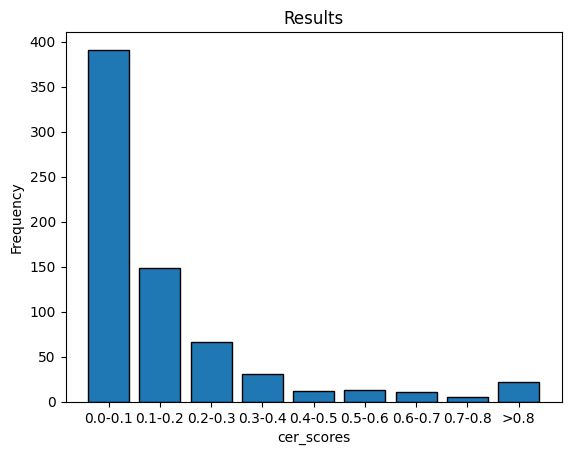

In [5]:
bins = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, float('inf')]
bin_counts = np.histogram(cer_values, bins=bins)[0]
bin_labels = ['0.0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8', '>0.8']
plt.bar(bin_labels, bin_counts, edgecolor='black')
plt.xlabel('cer_scores')
plt.ylabel('Frequency')
plt.title('Results')
plt.show()